# Setup

In [ ]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from select_disease_cohort import *
from select_patient_info import *

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, RocCurveDisplay


# Constants
GROUP_COL = 'subject_id' # Identifier for patients
VISIT_COL = 'hadm_id' # Identifier for visits
ADMIT_COL = 'admittime' # Admission time
DISCH_COL = 'dischtime' # Discharge time
GAP = datetime.timedelta(days=14) # Gap for within readmission must occur
DISEASE_LABEL = 'I50' # or I50 = Heart Failure, # I25 = Coronary Artery Disease, # N18 = Chronic Kidney Disease, # J44 = Chronic obstructive pulmonary disease
VERSION = '1.0' # MIMIC-IV version 1.0 or 2.0

# Results so far for READMISSION PREDICTION
# I25, GAP=14, MIMIC-IV 2.0, --> ROC-AUC = .57
# I25, GAP=7, MIMIC-IV 2.0, --> ROC-AUC = .52
# I550, GAP=7, MIMIC-IV 2.0, --> ROC-AUC = .46
# I550, GAP=30, MIMIC-IV 2.0, --> ROC-AUC = .56

# Results so far for DEATH PREDICTION
# I50, GAP=14, MIMIC-IV 2.0, --> ROC-AUC = .80
# I25, GAP=14, MIMIC-IV 2.0, --> ROC-AUC = .66

# Paths
PATH_ADMISSIONS: str = os.path.join("mimiciv", VERSION, "core", "admissions.csv.gz")
PATH_DIAGNOSES_ICD: str = os.path.join("mimiciv", VERSION, "hosp", "diagnoses_icd.csv.gz")
PATH_PATIENTS: str = os.path.join("mimiciv", VERSION, "core", "patients.csv.gz")
PATH_OMR: str = os.path.join("mimiciv", VERSION, "hosp", "omr.csv.gz")
PATH_PRESCRIPTIONS: str = os.path.join("mimiciv", VERSION, "hosp", "prescriptions.csv.gz")
PATH_ICD_MAP: str = os.path.join("utils", "ICD9_to_ICD10_mapping.txt")

# Loading admissions, selecting disease cohort

In [ ]:
# From admissions df, standardize ICD codes (9 and 10 are mixed) and select disease cohort based on disease label (ICD10)
visit_df = standardize_codes_and_select_cohort(disease_label=DISEASE_LABEL, path_admissions_df=PATH_ADMISSIONS, filter_deaths=False)

# Adding patient df info (and basic vars from omr in case of MIMIC-IV 2.0)

In [3]:
# Appends data from patients_df to visit_df, e.g. age, gender, ethnicity, marital status
# And also comorbidities
visit_pts_df = get_patient_df_info(version=VERSION, visit_df=visit_df)
visit_pts_df = get_comorbidities(get_diagnosis_icd_df(), visit_pts_df)
visit_pts_df = visit_pts_df.sort_values(['subject_id', 'admittime']).reset_index(drop=True)

In [4]:
# Adding omr basic physical variables via row-wise operations
visit_pts_df['bmi'] = visit_pts_df.apply(find_closest_bmi, axis=1)
visit_pts_df.dropna(subset=['bmi'],inplace=True) # Has a lot of missing values, because omr = outpatient measurements 

# Create cols for systolic and diastolic blood pressure
visit_pts_df['bp_systolic'] = visit_pts_df.apply(find_closest_bp_systolic, axis=1)
visit_pts_df['bp_diastolic'] = visit_pts_df.apply(find_closest_bp_diastolic, axis=1)

visit_pts_df.dropna(subset=['bp_systolic'],inplace=True) # Has a lot of missing values, because omr = outpatient measurements 
visit_pts_df.dropna(subset=['bp_diastolic'],inplace=True) 

# Adding number of medications per visit. Has no missings as it is lookup over hadm_id
visit_pts_df['presc_meds'] = visit_pts_df.apply(get_med_prescs, axis=1)

# ML Tasks

## Death prediction

In [5]:
# Task spec
task = "death_pred"
# Creating targets and balancing set)
visit_pts_df.loc[visit_pts_df['hospital_expire_flag'] == 1, 'y_label'] = 1
visit_pts_df.loc[visit_pts_df['dod'].isna(), 'y_label'] = 0
visit_pts_df.loc[visit_pts_df['hospital_expire_flag'] == 0, 'y_label'] = 0

# Creating targets and balancing set)
case_df = visit_pts_df[visit_pts_df.y_label == 1]
control_df = visit_pts_df[visit_pts_df.y_label == 0]

### Write

In [6]:
case_df.to_csv(os.path.join('output',f"{task + '_' + DISEASE_LABEL + '_GAP'+ str(GAP.days) + '_MIMIC_IV' + '_' + VERSION + '_case_df2.csv'}"),index_label=False)
control_df.to_csv(os.path.join('output', f"{task + '_' + DISEASE_LABEL + '_GAP'+ str(GAP.days) + '_MIMIC_IV' + '_' + VERSION + '_control_df2.csv'}"),index_label=False)

### Read

In [7]:
# Read
case_df = pd.read_csv(os.path.join('output',f"{task + '_' + DISEASE_LABEL + '_GAP'+ str(GAP.days) + '_MIMIC_IV' + '_' + VERSION + '_case_df2.csv'}"),index_col=0)
control_df = pd.read_csv(os.path.join('output',f"{task + '_' + DISEASE_LABEL + '_GAP'+ str(GAP.days) + '_MIMIC_IV' + '_' + VERSION + '_control_df2.csv'}"),index_col=0)

### Train

In [ ]:
# Creating targets and balancing set)
visit_pts_df.loc[visit_pts_df['hospital_expire_flag'] == 1, 'y_label'] = 1
visit_pts_df.loc[visit_pts_df['dod'].isna(), 'y_label'] = 0
visit_pts_df.loc[visit_pts_df['hospital_expire_flag'] == 0, 'y_label'] = 0

# Creating targets and balancing set)
case_df = visit_pts_df[visit_pts_df.y_label == 1]
control_df = visit_pts_df[visit_pts_df.y_label == 0]

print(f"Positive cases: {len(case_df)}")
print(f"Negative cases: {len(control_df)}")

control_df = control_df.sample(len(case_df),random_state=42)

# Concatenate
ml_df = pd.concat([case_df, control_df], axis=0)
ml_df.reset_index(drop=True,inplace=True)

# Coerce variables to ints
ml_df['los_hours'] = ml_df['los_hours'].astype(int)
ml_df['age'] = ml_df['age'].astype(int)
ml_df['y_label'] = ml_df['y_label'].astype(int)
ml_df['comorbs'] = ml_df['comorbs'].astype(int)
ml_df['bmi'] = ml_df['bmi'].astype(float)
ml_df['bp_systolic'] = ml_df['bp_systolic'].astype(int)
ml_df['bp_diastolic'] = ml_df['bp_diastolic'].astype(int)
ml_df['presc_meds'] = ml_df['presc_meds'].astype(int)

# Create one-hot encodings for categorical features
categorical_columns = ['admission_type', 'admission_location',
       'insurance', 'ethnicity', 'marital_status', 'gender']  

encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(ml_df[categorical_columns])
feature_names = encoder.get_feature_names_out(categorical_columns)
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)

# Drop original categorical columns and concatenate with encoded ones
ml_df = pd.concat([ml_df.drop(categorical_columns, axis=1), encoded_df], axis=1)

# Selecting only properly encoded columns
ml_df = ml_df[['los_hours',
       'age', 'y_label', 'bmi','comorbs','bp_systolic','bp_diastolic', 
       'presc_meds',
       'admission_type_AMBULATORY OBSERVATION', 'admission_type_DIRECT EMER.',
       'admission_type_DIRECT OBSERVATION', 'admission_type_ELECTIVE',
       'admission_type_EU OBSERVATION', 'admission_type_EW EMER.',
       'admission_type_OBSERVATION ADMIT',
       'admission_type_SURGICAL SAME DAY ADMISSION', 'admission_type_URGENT',
       'admission_location_AMBULATORY SURGERY TRANSFER',
       'admission_location_CLINIC REFERRAL',
       'admission_location_EMERGENCY ROOM',
       'admission_location_INFORMATION NOT AVAILABLE',
       'admission_location_PACU', 'admission_location_PHYSICIAN REFERRAL',
       'admission_location_PROCEDURE SITE',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_TRANSFER FROM SKILLED NURSING FACILITY',
       'admission_location_WALK-IN/SELF REFERRAL', 'insurance_Medicaid',
       'insurance_Medicare', 'insurance_Other',
       'ethnicity_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_ASIAN',
       'ethnicity_BLACK/AFRICAN AMERICAN',
       'ethnicity_OTHER', 
       'ethnicity_UNABLE TO OBTAIN',
       'ethnicity_UNKNOWN',
       'ethnicity_WHITE', 'marital_status_DIVORCED', 'marital_status_MARRIED',
       'marital_status_SINGLE', 'marital_status_WIDOWED', 'marital_status_nan',
       'gender_F', 'gender_M']]

X = ml_df.drop('y_label', axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = ml_df['y_label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# GS
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear','saga'],
    'tol': [1e-4, 1e-3, 1e-2], 
    'l1_ratio': [0.1, 0.3, 0.5, 0.7]
    }

# Create and fit grid search
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=5,
    scoring='f1_macro',
    refit=True,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Print best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}") 

# Training quick model
#model = LogisticRegression(penalty='l2', max_iter=5000, C=0.1)
#model.fit(X_train, y_train)



### Eval

In [ ]:
# Predict
y_pred = grid_search.predict(X_test)
#y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

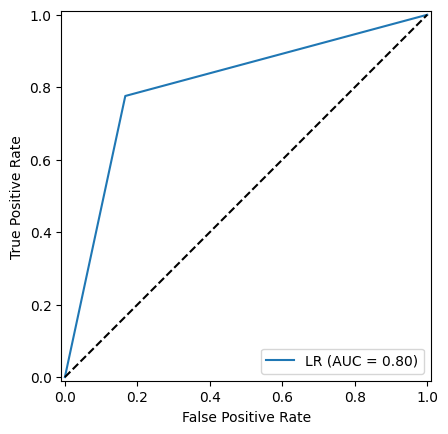

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name=f'LR')
display.plot()
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.show()

### Write resulting dataset

In [19]:
ml_df.to_csv(os.path.join('output',f"{task + '_' + DISEASE_LABEL + '_GAP'+ str(GAP.days) + '_MIMIC_IV' + '_' + VERSION + '_ml_df2.csv'}"),index_label=False)

## Readmission task

### Creating partitions based on readmission gap

In [20]:
# Task spec
task = "readmit_pred"
# These are expensive to run, so we write to 'output' folder
case_df, control_df, invalid_df, redundant_df = partition_by_readmit(visit_pts_df,gap=GAP,group_col=GROUP_COL,visit_col=VISIT_COL,admit_col=ADMIT_COL,disch_col=DISCH_COL)

100%|██████████| 13800/13800 [02:48<00:00, 81.90it/s]

[ READMISSION LABELS FINISHED ]


### Write

In [22]:
case_df.to_csv(os.path.join('output',f"{task + '_' + DISEASE_LABEL + '_GAP'+ str(GAP.days) + '_MIMIC_IV' + '_' + VERSION + '_case_df.csv'}"),index_label=False)
control_df.to_csv(os.path.join('output', f"{task + '_' + DISEASE_LABEL + '_GAP'+ str(GAP.days) + '_MIMIC_IV' + '_' + VERSION + '_control_df.csv'}"),index_label=False)
invalid_df.to_csv(os.path.join('output', f"{task + '_' + DISEASE_LABEL + '_GAP'+ str(GAP.days) + '_MIMIC_IV' + '_' + VERSION + '_invalid_df.csv'}"),index_label=False)
redundant_df.to_csv(os.path.join('output', f"{task + '_' + DISEASE_LABEL + '_GAP'+ str(GAP.days) + '_MIMIC_IV' + '_' + VERSION + '_redundant_df.csv'}"),index_label=False)

### Read

In [9]:
# Read
case_df = pd.read_csv(os.path.join('output',f"{task + '_' + DISEASE_LABEL + '_GAP'+ str(GAP.days) + '_MIMIC_IV' + '_' + VERSION + '_case_df.csv'}"),index_col=0)
control_df = pd.read_csv(os.path.join('output',f"{task + '_' + DISEASE_LABEL + '_GAP'+ str(GAP.days) + '_MIMIC_IV' + '_' + VERSION + '_control_df.csv'}"),index_col=0)

### Train

In [ ]:
# Creating targets and balancing set
case_df['y_label'] = np.array([1] * len(case_df))
control_df['y_label'] = np.array([0] * len(control_df))

print(f"Positive cases: {len(case_df)}")
print(f"Negative cases: {len(control_df)}")

control_df = control_df.sample(len(case_df),random_state=42)

# Concatenate
ml_df = pd.concat([case_df, control_df], axis=0)
ml_df.reset_index(drop=True,inplace=True)

# Coerce variables to ints
ml_df['los_hours'] = ml_df['los_hours'].astype(int)
ml_df['age'] = ml_df['age'].astype(int)
ml_df['y_label'] = ml_df['y_label'].astype(int)
ml_df['comorbs'] = ml_df['comorbs'].astype(int)
ml_df['bmi'] = ml_df['bmi'].astype(float)
ml_df['bp_systolic'] = ml_df['bp_systolic'].astype(int)
ml_df['bp_diastolic'] = ml_df['bp_diastolic'].astype(int)
ml_df['presc_meds'] = ml_df['presc_meds'].astype(int)

# Create one-hot encodings for categorical features
categorical_columns = ['admission_type', 'admission_location',
       'insurance', 'ethnicity', 'marital_status', 'gender']  

encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(ml_df[categorical_columns])
feature_names = encoder.get_feature_names_out(categorical_columns)
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)

# Drop original categorical columns and concatenate with encoded ones
ml_df = pd.concat([ml_df.drop(categorical_columns, axis=1), encoded_df], axis=1)

# Z-score features
from sklearn.preprocessing import StandardScaler

# Selecting only properly encoded columns
ml_df = ml_df[['los_hours',
       'age', 'y_label', 'bmi','comorbs','bp_systolic','bp_diastolic', 
       'presc_meds',
       'admission_type_AMBULATORY OBSERVATION', 'admission_type_DIRECT EMER.',
       'admission_type_DIRECT OBSERVATION', 'admission_type_ELECTIVE',
       'admission_type_EU OBSERVATION', 'admission_type_EW EMER.',
       'admission_type_OBSERVATION ADMIT',
       'admission_type_SURGICAL SAME DAY ADMISSION', 'admission_type_URGENT',
       #'admission_location_AMBULATORY SURGERY TRANSFER',
       'admission_location_CLINIC REFERRAL',
       'admission_location_EMERGENCY ROOM',
       'admission_location_INFORMATION NOT AVAILABLE',
       'admission_location_PACU', 'admission_location_PHYSICIAN REFERRAL',
       'admission_location_PROCEDURE SITE',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_TRANSFER FROM SKILLED NURSING FACILITY',
       'admission_location_WALK-IN/SELF REFERRAL', 'insurance_Medicaid',
       'insurance_Medicare', 'insurance_Other',
       'ethnicity_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_ASIAN',
       'ethnicity_BLACK/AFRICAN AMERICAN',
       'ethnicity_OTHER', 
       #'ethnicity_UNABLE TO OBTAIN',
       'ethnicity_UNKNOWN',
       'ethnicity_WHITE', 'marital_status_DIVORCED', 'marital_status_MARRIED',
       'marital_status_SINGLE', 'marital_status_WIDOWED', 'marital_status_nan',
       'gender_F', 'gender_M']]

X = ml_df.drop('y_label', axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = ml_df['y_label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# GS
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10,],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear','saga'],
    'tol': [1e-4, 1e-3, 1e-2], 
    'l1_ratio': [0.1, 0.3, 0.5, 0.7]
    }

# Create and fit grid search
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=5,
    scoring='f1_macro',
    refit=True,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Print best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}") 

# Training quick model
#model = LogisticRegression(penalty='l2', max_iter=5000, C=2)
#model.fit(X_train, y_train)

### Eval

In [24]:
# Predict
y_pred = grid_search.predict(X_test)
#y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.52      0.53       261
           1       0.52      0.54      0.53       247

    accuracy                           0.53       508
   macro avg       0.53      0.53      0.53       508
weighted avg       0.53      0.53      0.53       508



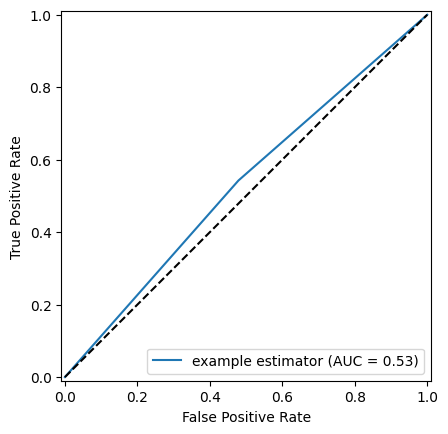

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='LR')
display.plot()
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.show()

## Sanity check

In [13]:
# Sanity checks
print(ml_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3218 entries, 0 to 3217
Data columns (total 42 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   los_hours                                                  3218 non-null   int64  
 1   age                                                        3218 non-null   int64  
 2   y_label                                                    3218 non-null   int64  
 3   bmi                                                        3218 non-null   float64
 4   comorbs                                                    3218 non-null   int64  
 5   bp_systolic                                                3218 non-null   int64  
 6   bp_diastolic                                               3218 non-null   int64  
 7   presc_meds                                                 3218 non-null   int64  
 8   admissio